# Bending of 1D Cantilever Beam Under Point Load

## Problem Statement

Let us consider a problem similar to the [Euler Beam](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/eulerbeam.html) example given in DeepXDE documentation. We will consider a simple 1D cantilever beam of length $L = 1\ m$, that is fixed at the left end and free at the right end. The width and height of the beam are equal : $h = b = 0.1\ m$. Thus its second moment of area is given by : $I = bh^3/12$. A force $P = 100\ kN$ is applied in the downlward direction at the free end. The Young's modulus of elasitcity of the beam is $ E = 200\ GPa$. The deflection in the $y$ direction is denoted by the symbol $u$. The governing equations and the boundary conditions are given in the next section.

## Governing Equation

**Governing ODE (for $x \in [0, L]$):**
- $d^4 u/dx^4 = 0$

**Left B.C (at $x = 0$) :**
- $u = 0$
- $d u/dx = 0$

**Right B.C (at $x = L$) :**
- $ d^2 u/dx^2 = 0 $
- $ d^3 u/dx^3 + P/(EI) = 0 $


## Import Libraries

In [1]:
import torch
import deepxde as dde
import numpy as np
import tensorflow as tf

# Set backend to PyTorch and use CPU
dde.backend.backend_name = "pytorch"

# Set seed for reproducibility  
dde.config.set_random_seed(42)  


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Set Device: CPU or GPU

**Check if GPU is available**

In [2]:
# Check if GPU is available
print("#"*17)
print("CUDA available:", torch.cuda.is_available())
print("Default CUDA device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
print("#"*17)

# Check if GPU is available for DeepXDE
print(f"GPU available for DeepXDE: {dde.backend.is_gpu_available()}")
print("#"*17)


#################
CUDA available: True
Default CUDA device: 0
Device name: NVIDIA RTX 2000 Ada Generation Laptop GPU
#################
GPU available for DeepXDE: True
#################


**Select device for running the neural network**

(Since our network is small, using CPU be faster).

In [3]:
# Select device for computation
device = "cpu" # must be set for both PyTroch and DeepXDE ("net" variable of DeepXDE)

# Create dummy tensor for testing
torch.set_default_device(device)
a = torch.tensor([1.0, 2.0])

print("#"*17)
print("PyTorch tensors stored in :", a.device)  # Should show: cuda:0
print("#"*17)


#################
PyTorch tensors stored in : cpu
#################


## Parameters and Geometry

In [4]:
##############
# Parameters
L   = 1.0       # lenght of beam [in m]
h   = 0.1       # height of beam [in m]
b   = 0.1       # width of beam [in m]
E   = 200e9     # Youngs Modulus of elasticity [in Pa]
P   = -100e3    # force [in N]
I   = b*h**3/12 # moment of inertia (bending in y-direction) [in m^4]

##############
# Check the order of "P/EI" term
print(f"P/(E.I) = {P/(E*I):.3f}")

##############
# Geometry
geom = dde.geometry.Interval(0, L)


P/(E.I) = -0.060


## Normalization Params

It is best to normalized the equations because neural-networks are not very good at predicting very large or very small numbers.

**Max-Normalization :**
$$ \hat{u} = \frac{u}{u_{max}} $$

**Maximum deflection in 1D beam (analytical solution) :**

$$ u_{max} = \frac{P L^3}{3 E I} $$


In [5]:
# Maximum deflection analytical solution
uy_max_exact = P*L**3 / (3*E*I)
print(f"uy_max_exact  = {uy_max_exact:.3f} m")

# Normalization value (higher than analytical solution)
uy_max = 0.1 # in m
print(f"uy_max for normalization = {uy_max:.3f} m")

uy_max_exact  = -0.020 m
uy_max for normalization = 0.100 m


## Exact Solution

**Analytical solution for deflection in 1D beam :**

$$ u(x) = \frac{P x^2}{6EI} (3L - x) $$


In [6]:
# exact solution (normalized)
def func_exact_solution(x):
    uy = P*x**2 * (3*L - x) / (6*E*I)
    uy_norm = uy/uy_max
    return uy_norm


## Governing ODE

**Normalized Governing ODE (for $x \in [0, L]$):**

Substitute $u = \hat{u} \cdot u_{max}$ in the original governing ODE:

- $d^4 \hat{u}/dx^4 = 0$


In [ ]:
##############
# PDE definition
def pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x, i=0, j=0)
    d4y_dx4 = dde.grad.hessian(d2y_dx2, x, i=0, j=0)
    residual = d4y_dx4
    return residual


## Boundary Conditions

Substitute $u = \hat{u} \cdot u_{max}$ in the original B.C equations:

**Normalized Left B.C (at $x = 0$) :**
- $\hat{u} = 0$
- $d \hat{u}/dx = 0$

**Normalized Right B.C (at $x = L$) :**
- $ d^2 \hat{u}/dx^2 = 0 $
- $ u_{max} \cdot d^3 \hat{u}/dx^3 + P/(EI) = 0 $

In [8]:
##############
# Derivative functions
def func_d2y_dx2(x, y):
    d2y_dx2 = dde.grad.hessian(y, x, i=0, j=0)
    return d2y_dx2

def func_d3y_dx3(x, y):
    d2y_dx2 = func_d2y_dx2(x, y)
    d3y_dx3 = dde.grad.jacobian(d2y_dx2, x, i=0, j=0)
    return d3y_dx3

##############
# Right boundary (x = L)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

##############
# Left boundary (x = 0)
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

##############
# left boundary
bc_left_d = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary_left) # y = 0
bc_left_n = dde.icbc.NeumannBC(geom, lambda x: 0.0, boundary_left) # dy_dx = 0

##############
# right boundary
bc_right_o_d2y = dde.icbc.OperatorBC(geom, lambda x, y, _ : ( func_d2y_dx2(x, y) ), boundary_right) # d2y_dx^2 = 0
bc_right_o_d3y = dde.icbc.OperatorBC(geom, lambda x, y, _ : ( uy_max*func_d3y_dx3(x, y) + P/(E*I) ), boundary_right) # d3y_dx3 + P/(E*I) = 0



## Network Setup

In [9]:
##############
# Define the data
data = dde.data.PDE(geom, pde, 
                    [bc_left_d, bc_left_n, bc_right_o_d2y, bc_right_o_d3y], 
                    num_domain=64, num_boundary=16,
                    solution=func_exact_solution,
                    num_test=100)

##############
# Neural network
net = dde.nn.FNN([1] + [20]*3 + [1], "tanh", "Glorot uniform")
net.to(device)
print("DeepXDE network is on :", next(net.parameters()).device)


DeepXDE network is on : cpu


## Run Model

### `Adam` Optimizer

The hyperparameters `lr`, `loss_weights` and `decay` have been selected through trial and error. 

In [10]:
##############
# Model Creation
model = dde.Model(data, net)

model.compile("adam", lr=1e-2,
              metrics=["l2 relative error"],
              loss_weights=[1e4, 1e4, 1e4, 1e4, 1e4],
              decay=("step", 500, 0.8))

# Model training
losshistory, train_state = model.train(iterations=2_500, display_every=500)


Compiling model...
'compile' took 2.778202 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.68e+03, 0.00e+00, 1.02e+03, 3.69e+02, 4.14e+01]    [2.07e+03, 0.00e+00, 1.02e+03, 3.69e+02, 4.14e+01]    [6.94e-01]    
500       [8.51e-01, 1.31e-03, 1.80e-03, 1.76e-01, 2.59e+01]    [6.14e-01, 1.31e-03, 1.80e-03, 1.76e-01, 2.59e+01]    [8.63e-01]    
1000      [4.38e-02, 6.59e-03, 1.59e-05, 8.93e-07, 1.96e-02]    [3.84e-02, 6.59e-03, 1.59e-05, 8.93e-07, 1.96e-02]    [3.01e-02]    
1500      [3.63e-02, 1.47e-08, 4.30e-09, 8.34e-12, 3.12e-04]    [3.80e-02, 1.47e-08, 4.30e-09, 8.34e-12, 3.12e-04]    [3.22e-03]    
2000      [2.62e-01, 2.91e+00, 2.50e-04, 3.41e-02, 1.84e-03]    [2.94e-01, 2.91e+00, 2.50e-04, 3.41e-02, 1.84e-03]    [1.69e-01]    
2500      [3.01e-02, 2.21e-03, 5.84e-07, 2.49e-05, 7.03e-04]    [3.08e-02, 2.21e-03, 5.84e-07, 2.49e-05, 7.03e-04]    [8.76e-03]    

Bes

### `L-BFGS-B` Algorithm

In [11]:
# For finer convergence
model.compile("L-BFGS-B", metrics=["l2 relative error"])  
losshistory, train_state = model.train()


Compiling model...
'compile' took 0.000330 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
2500      [3.01e-06, 2.21e-07, 5.84e-11, 2.49e-09, 7.03e-08]    [3.08e-06, 2.21e-07, 5.84e-11, 2.49e-09, 7.03e-08]    [8.76e-03]    

Best model at step 2500:
  train loss: 3.30e-06
  test loss: 3.38e-06
  test metric: [8.76e-03]

'train' took 0.023454 s



## Visualization

### Numerical Values

In [12]:
# Prediction
X = np.linspace(0, L, 100).reshape(-1, 1)
y_pred_norm = model.predict(X)
y_exact_norm = func_exact_solution(X)

# De-normalized
y_pred = y_pred_norm*uy_max
y_exact = y_exact_norm*uy_max

# Print
print("#"*17)
print(f'y_pred at left boundary   : {y_pred[0, 0]*1e3:.2f} mm')
print(f'y_exact at left boundary  : {y_exact[0, 0]*1e3:.2f} mm')
print("#"*17)
print(f'y_pred at right boundary  : {y_pred[-1, 0]*1e3:.2f} mm')
print(f'y_exact at right boundary : {y_exact[-1, 0]*1e3:.2f} mm')
print("#"*17)


#################
y_pred at left boundary   : 0.05 mm
y_exact at left boundary  : -0.00 mm
#################
y_pred at right boundary  : -19.86 mm
y_exact at right boundary : -20.00 mm
#################


### Plot

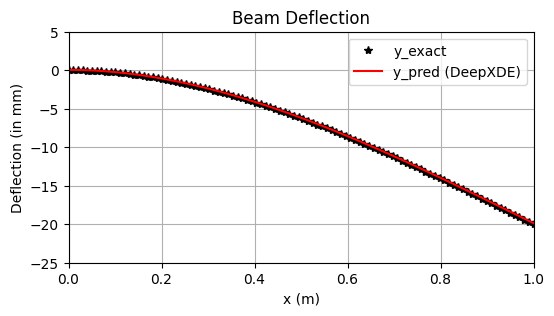

In [13]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(X, y_exact*1000, "*k", label="y_exact")
plt.plot(X, y_pred*1000, "r", label="y_pred (DeepXDE)")
plt.xlabel("x (m)")
plt.ylabel("Deflection (in mm)")
plt.title("Beam Deflection")
plt.axis([0, L, -25, 5])
plt.legend()
plt.grid(True)
plt.show()
